# Apply of the CRISP-DM data mining methodology to analyse the data

In this notebook we're going to apply the steps of the CRISP-DM data mining methodology to analyse the data

The dataset we choose for this project: Crime Investigation. Link: https://github.com/neo4j-graph-examples/pole

# Installing necessary libraries

In [1]:
!pip install py2neo pandas
!pip install py2neo pandas matplotlib

# Loading necessary libraries

In [1]:
from py2neo import Graph

import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score

# Section-1: Loading the database into our local neo4j database
In this section, at first, we created a local database into our Neo4j Desktop named: stackoverflowdb. We choose the db version: 5.5.0

Then apply the following credentials to connnect to our local database:

In [2]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678")) 

After that, we downloaded the crime investigation repo from https://github.com/neo4j-graph-examples/pole

After extracting the zip file, pole-50.dump from data folder has been loaded into neo4j desktop. Then database has been created from the dump file.

# Section-2: EDA

Schema visualization

In [3]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('Vehicle', constraints=[], indexes=[], name='Vehicle'),
   Node('Area', constraints=[], indexes=['areaCode'], name='Area'),
   Node('Email', constraints=[], indexes=[], name='Email'),
   Node('Phone', constraints=[], indexes=[], name='Phone'),
   Node('Crime', constraints=[], indexes=['last_outcome', 'type'], name='Crime'),
   Node('PhoneCall', constraints=[], indexes=[], name='PhoneCall'),
   Node('Object', constraints=[], indexes=['type'], name='Object'),
   Node('PostCode', constraints=[], indexes=['code'], name='PostCode'),
   Node('Person', constraints=[], indexes=['name', 'nhs_no', 'surname'], name='Person'),
   Node('Location', constraints=[], indexes=['postcode', 'address'], name='Location'),
   Node('Officer', constraints=[], indexes=['rank', 'surname'], name='Officer')],
  'relationships': [INVOLVED_IN(Node(), Node()),
   INVOLVED_IN(Node(), Node()),
   CALLER(Node(), Node()),
   KNOWS_PHONE(Node(), Node()),
   FAMILY_REL(Node(), Node()),
   INVESTIGATED_BY(N

After running this code into neo4j Browser, the following graph has been generated

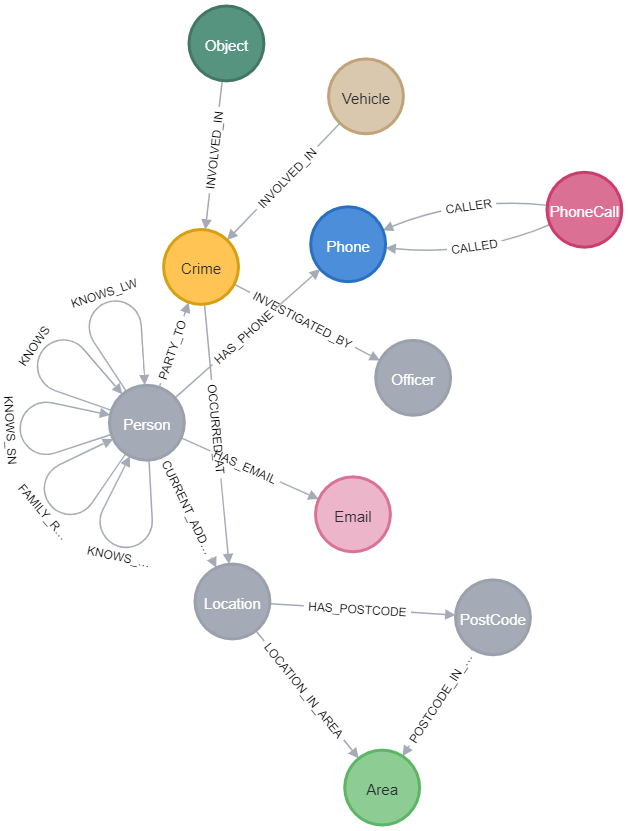

No of nodes per label

In [4]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
9,Object,7
6,Area,93
2,Phone,328
3,Email,328
0,Person,369
7,PhoneCall,534
4,Officer,1000
10,Vehicle,1000
5,PostCode,14196
1,Location,14904


Visualization using matplotlib

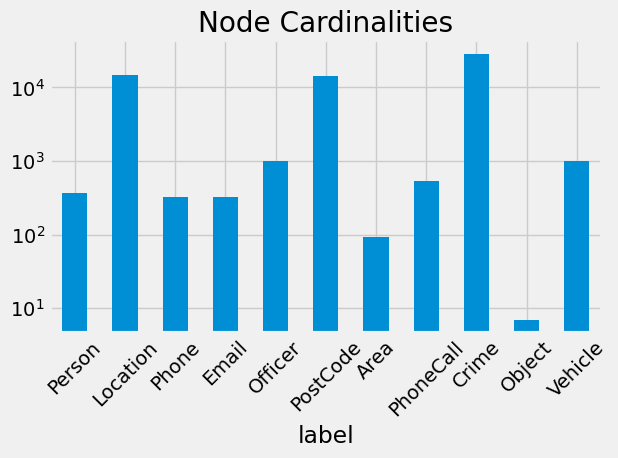

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of types of relationships

In [6]:
result = {"Relationship Type": [], "Count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as Count"
    count = graph.run(query).to_data_frame().iloc[0]['Count']
    result["Relationship Type"].append(relationship_type)
    result["Count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("Count")


,Relationship Type,Count
14,PARTY_TO,55
16,KNOWS_LW,80
10,KNOWS_PHONE,118
15,FAMILY_REL,155
6,KNOWS_SN,241
1,HAS_PHONE,328
2,HAS_EMAIL,328
0,CURRENT_ADDRESS,368
9,CALLED,534
8,CALLER,534


Visualization of the Relationship count result

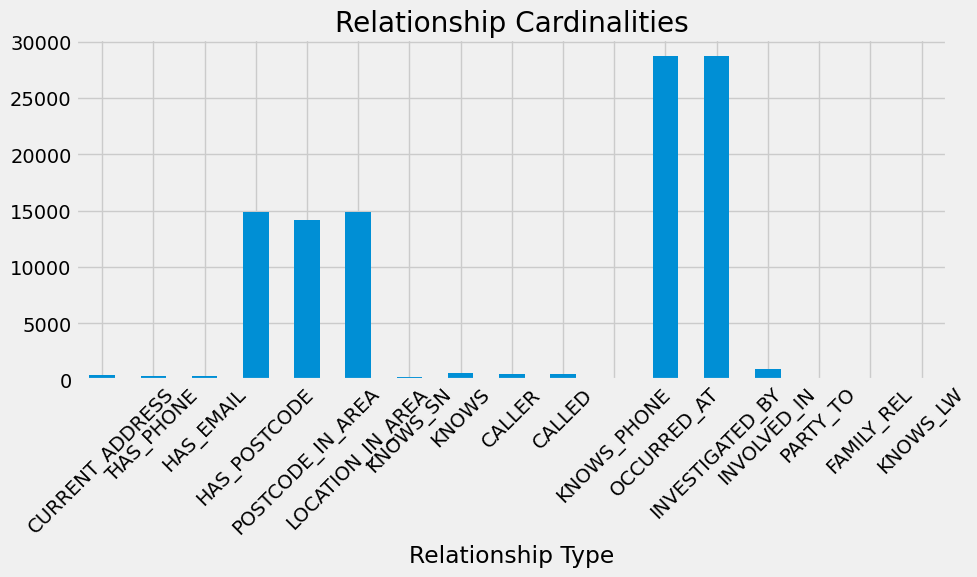

In [8]:
rels_df.plot(kind='bar', x='Relationship Type', y='Count', legend=None, title="Relationship Cardinalities", figsize=(10,6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of labels

In [9]:
query = """ MATCH (n) RETURN labels(n) as Label, count(*) as Count; """
result = pd.DataFrame(graph.run(query).to_data_frame())
result_dict = {'Label': [], 'Count': []}
result['Label'] = [line for line in result['Label'].str[0]]
result['Count'] = [line for line in result['Count']]
result_df = pd.DataFrame(result)
result_df

,Label,Count
0,Person,369
1,Location,14904
2,Phone,328
3,Email,328
4,Officer,1000
5,Crime,28762
6,PhoneCall,534
7,PostCode,14196
8,Area,93
9,Vehicle,1000


Visualization of Label vs Count

<AxesSubplot: title={'center': 'Label vs Count'}, xlabel='Label'>

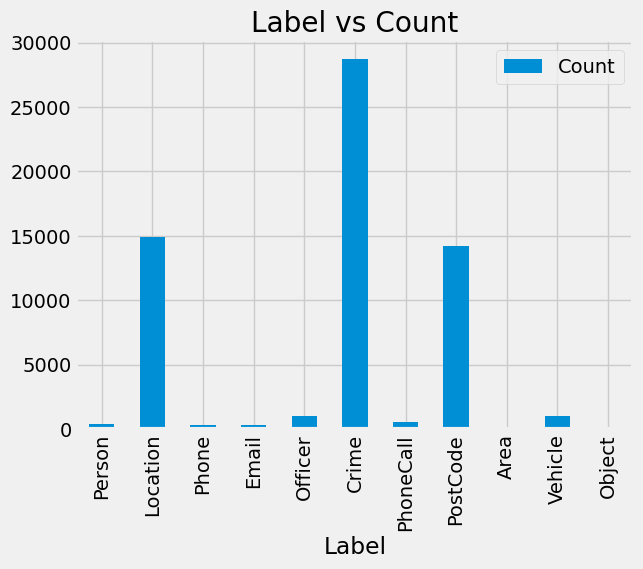

In [10]:
result_df.plot(x='Label', y='Count', kind='bar', title='Label vs Count')

Total crimes

In [15]:
query = """MATCH (c:Crime) RETURN c.type AS `Crime Type`, count(c) AS Total ORDER BY count(c) DESC;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Crime Type,Total
0,Violence and sexual offences,8765
1,Public order,4839
2,Criminal damage and arson,3587
3,Burglary,2807
4,Vehicle crime,2598
5,Other theft,2140
6,Shoplifting,1427
7,Other crime,651
8,Robbery,541
9,Theft from the person,423


Visualization of Crime Type vs Total

<AxesSubplot: title={'center': 'Crime Type vs Total'}, xlabel='Crime Type'>

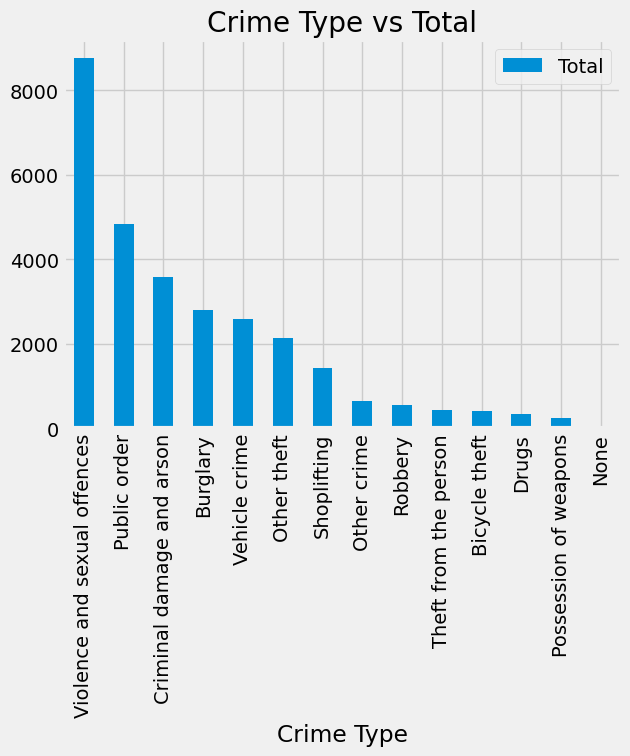

In [17]:
result.plot(x='Crime Type', y='Total', kind='bar', title='Crime Type vs Total')

Top locations for crimes

In [18]:
query = """MATCH (l:Location)<-[:OCCURRED_AT]-(:Crime) RETURN l.address AS Address, l.postcode AS `Post Code`, count(l) AS Total ORDER BY count(l) DESC LIMIT 15;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Address,Post Code,Total
0,Piccadilly,M1 1LU,166
1,Shopping Area,M60 1TA,111
2,Prison,M60 9AH,48
3,Shopping Area,M4 3AL,46
4,Nightclub,M1 3LZ,41
5,Parking Area,M90 2AY,38
6,Supermarket,WN7 5SJ,38
7,Nightclub,M4 2BS,36
8,182 Waterson Avenue,M40 9BY,35
9,43 Walker's Croft,M3 1DA,35


Visualiztion of top locations for crimes

<AxesSubplot: title={'center': 'Top locations for crimes'}, xlabel='Address'>

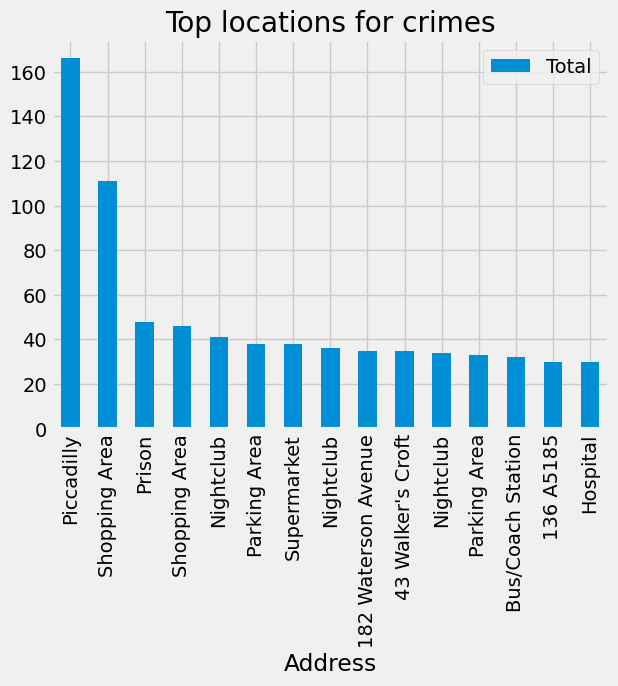

In [19]:
result.plot(x='Address', y='Total', kind='bar', title='Top locations for crimes')

Top ten users answering

In [25]:
query = """MATCH (User:User)-[:PROVIDED]->() RETURN User.display_name as Name, count(*) as Posts ORDER by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Posts
0,jose_bacoy,160
1,Charchit Kapoor,148
2,cybersam,68
3,Tomaž Bratanič,48
4,Graphileon,47
5,Michael Hunger,36
6,Christophe Willemsen,29
7,William Lyon,18
8,Vincent Rupp,14
9,nimrod serok,13


Visualization of top ten users answering posts

<AxesSubplot: title={'center': 'Top ten users answering posts'}, xlabel='Name'>

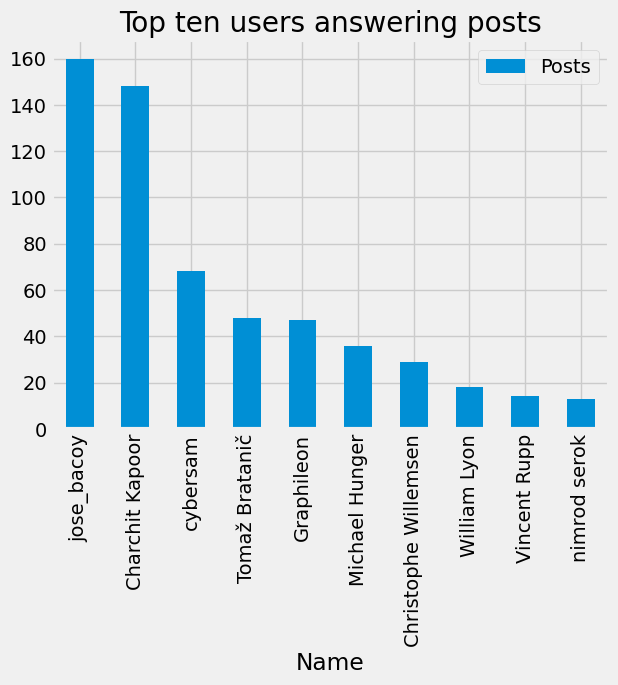

In [26]:
result.plot(x='Name', y='Posts', kind='bar', title='Top ten users answering posts')

Crimes near a particular address

In [23]:
query = """MATCH (l:Location {address: '178 Polding Street'})
WITH point(l) AS corrie
MATCH (x:Location)-[:HAS_POSTCODE]->(p:PostCode),
(x)<-[:OCCURRED_AT]-(c:Crime)
WITH x, p, c, point.distance(point(x), corrie) AS distance
WHERE distance < 500
RETURN x.address AS Address, p.code AS `Post code`, count(c) AS `Crime Total`, collect(distinct(c.type)) AS `Crime Type`, distance as Distance
ORDER BY distance
LIMIT 10"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Address,Post code,Crime Total,Crime Type,Distance
0,178 Polding Street,WN3 4NL,1,[Violence and sexual offences],0.000
1,58 Kinsley Close,WN3 4PQ,2,"[Public order, Violence and sexual offences]",175.555
2,63 Chatsworth Fold,WN3 4JA,1,[Violence and sexual offences],342.221
3,48 Cecil Street,WN3 4TS,3,"[Other theft, Vehicle crime, Violence and sexu...",388.287
4,134 Deakin Street,WN3 4NF,2,"[Public order, Violence and sexual offences]",416.302
5,32 Wessex Drive,WN3 4JJ,1,[Public order],419.941
6,26 Chester Close,WN3 4JP,1,[Vehicle crime],440.569
7,130 Sherbourne Place,WN3 4LL,1,[Criminal damage and arson],473.607
8,12 Banner Street,WN3 4NA,3,"[Violence and sexual offences, Drugs]",490.217


Crimes investigated by Inspector Wynn

In [24]:
query = """MATCH (o:Officer {rank: 'Chief Inspector', name: 'Wynn'})<-[i:INVESTIGATED_BY]-(c:Crime) RETURN *"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,c,i,o
0,"{'date': '9/08/2017', 'id': '94ef75e90f12f5921...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
1,"{'date': '22/08/2017', 'id': 'a2b7c8b9935872d5...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
2,"{'date': '22/08/2017', 'id': 'fccbbf25cb3c34ef...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
3,"{'date': '11/08/2017', 'id': '1a8d22f8ecae41f0...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
4,"{'date': '16/08/2017', 'id': 'e9eff939e8b4c201...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
5,"{'date': '29/08/2017', 'id': '9ed6e790d5dc6805...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
6,"{'date': '26/08/2017', 'id': '2f97aeb82017dc41...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
7,"{'date': '16/08/2017', 'id': '2c715693f9de6802...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
8,"{'date': '1/08/2017', 'id': '2c0411eff6b59ad0b...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."
9,"{'date': '11/08/2017', 'id': 'da6f4c29278b2093...",{},"{'badge_no': '38-1719233', 'surname': 'Makinso..."


Applying this query into neo4j desktop, we get the following graph:
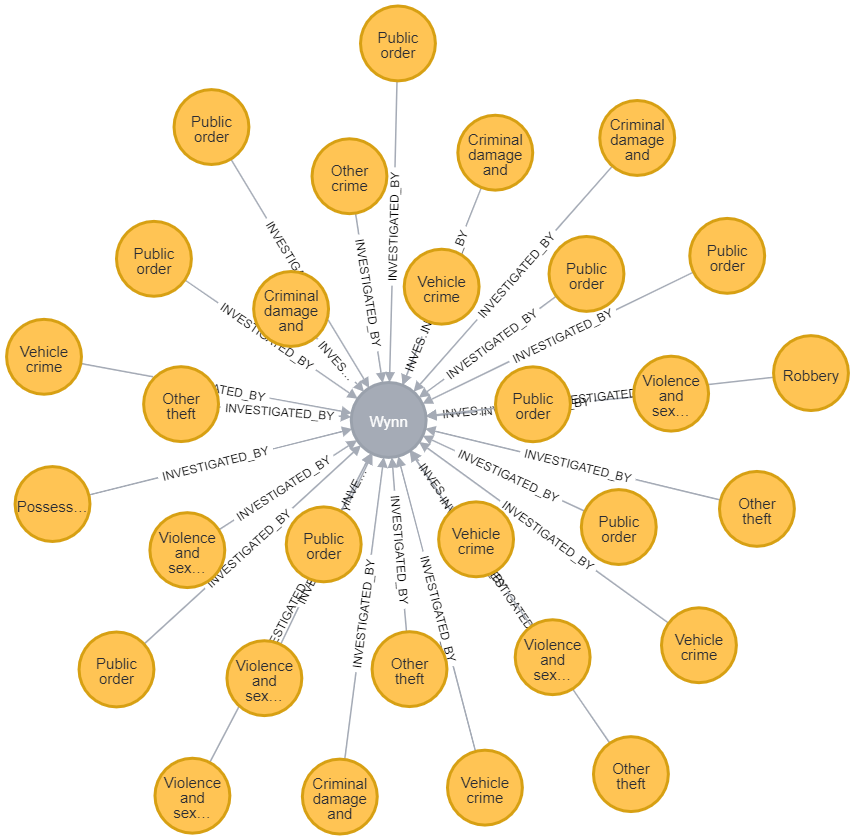

List of cases being investigated by officer Eimile

In [25]:
query = """MATCH (c:Crime {last_outcome: 'Under investigation'})-[i:INVESTIGATED_BY]->(o:Officer {badge_no: '18-0221971', name: 'Eimile'})
return *"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,c,i,o
0,"{'date': '21/08/2017', 'id': '80479e82bbd58787...",{},"{'badge_no': '18-0221971', 'surname': 'Lampet'..."
1,"{'date': '31/08/2017', 'id': 'b5c8906d935de5ad...",{},"{'badge_no': '18-0221971', 'surname': 'Lampet'..."
2,"{'date': '2/08/2017', 'id': 'c767d3a883dbc9583...",{},"{'badge_no': '18-0221971', 'surname': 'Lampet'..."
3,"{'date': '6/08/2017', 'id': 'cff386b54fb78fc74...",{},"{'badge_no': '18-0221971', 'surname': 'Lampet'..."
4,"{'date': '18/08/2017', 'id': '0adf05ba5fbbf1b6...",{},"{'badge_no': '18-0221971', 'surname': 'Lampet'..."


Applying this query into neo4j desktop, we get the following graph:

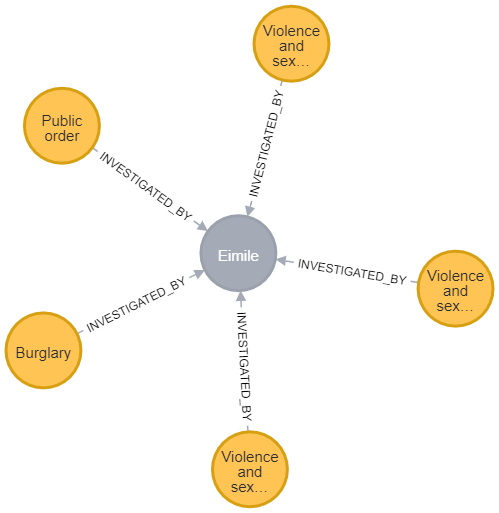

Shortest path between persons related to crimes: Drugs

In [26]:
query = """MATCH (c:Crime {last_outcome: 'Under investigation', type: 'Drugs'})-[:INVESTIGATED_BY]->(:Officer {badge_no: '26-5234182'}),
(c)<-[:PARTY_TO]-(p:Person)
WITH COLLECT(p) AS persons
UNWIND persons AS p1
UNWIND persons AS p2
WITH * WHERE id(p1) < id(p2)
MATCH path = allshortestpaths((p1)-[:KNOWS|KNOWS_LW|KNOWS_SN|FAMILY_REL|KNOWS_PHONE*..3]-(p2))
RETURN path"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,path
0,"({}, {}, {'rel_type': 'PARENT'})"
1,"({}, {}, {})"
2,"({'rel_type': 'PARENT'}, {}, {'rel_type': 'PAR..."
3,"({'rel_type': 'PARENT'}, {}, {})"
4,"({}, {}, {'rel_type': 'PARENT'})"
5,"({}, {}, {})"
6,"({'rel_type': 'PARENT'}, {}, {'rel_type': 'PAR..."
7,"({'rel_type': 'PARENT'}, {}, {})"
8,"({}, {}, {'rel_type': 'SIBLING'})"
9,"({}, {}, {})"


Applying this query into neo4j desktop, we get the following graph:

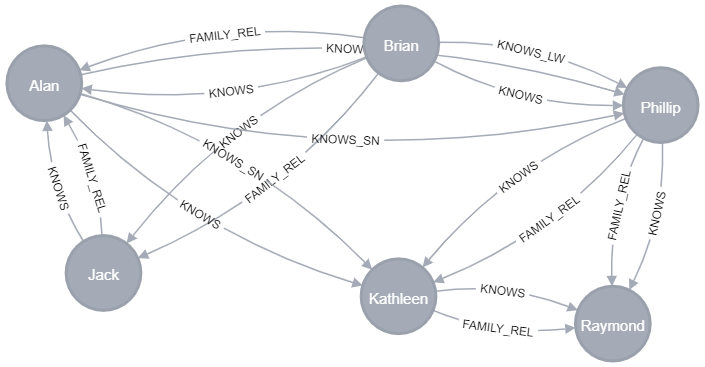

Related people associated with drugs crimes

In [27]:
query = """MATCH path = (:Officer {badge_no: '26-5234182'})<-[:INVESTIGATED_BY]-(:Crime {type: 'Drugs'})<-[:PARTY_TO]-(:Person)-[:KNOWS*..3]-(:Person)-[:PARTY_TO]->(:Crime {type: 'Drugs'}) RETURN path"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,path
0,"({}, {}, {}, {}, {})"
1,"({}, {}, {}, {}, {})"
2,"({}, {}, {}, {}, {})"
3,"({}, {}, {}, {}, {}, {})"
4,"({}, {}, {}, {}, {}, {})"
...,...
85,"({}, {}, {}, {}, {}, {})"
86,"({}, {}, {}, {}, {}, {})"
87,"({}, {}, {}, {}, {}, {})"
88,"({}, {}, {}, {}, {}, {})"


Applying this query into neo4j desktop, we get the following graph:

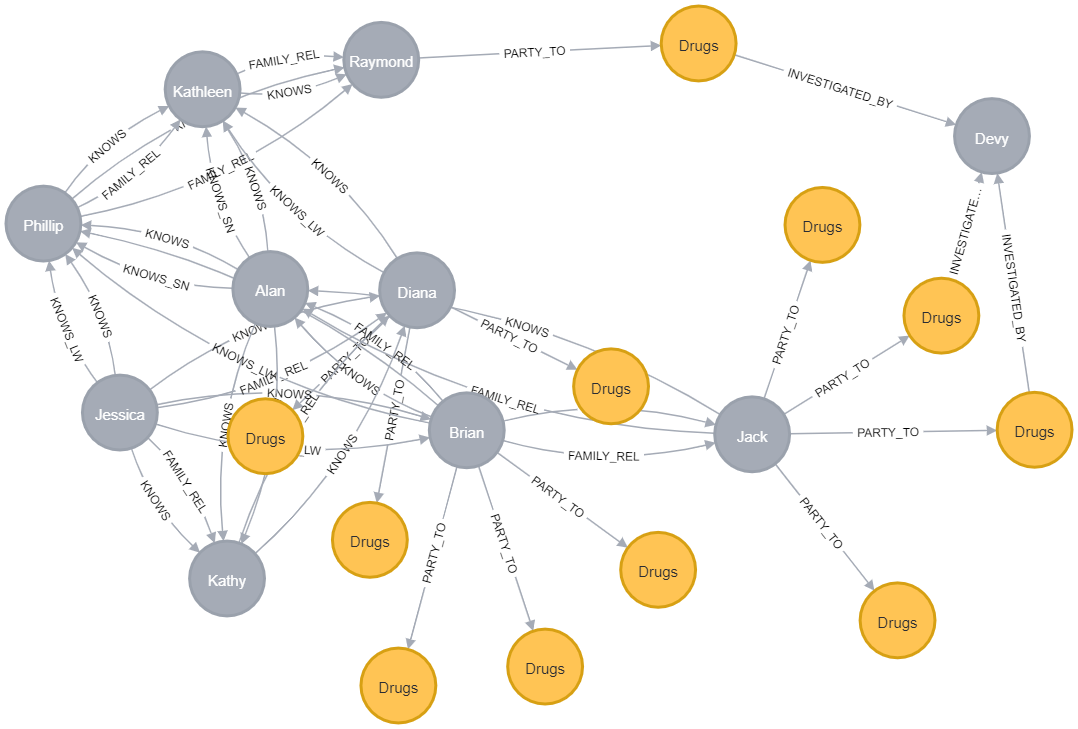

Top people at risk of bering associated with crimes in future

In [30]:
query = """MATCH (p:Person)-[:KNOWS]-(friend)-[:PARTY_TO]->(:Crime)
WHERE NOT (p:Person)-[:PARTY_TO]->(:Crime)
RETURN p.name AS Name, p.surname AS Surname, p.nhs_no AS id, count(distinct friend) AS `Dangerous Friends`
ORDER BY `Dangerous Friends` DESC
LIMIT 5"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Surname,id,Dangerous Friends
0,Anne,Freeman,804-54-6976,8
1,Bonnie,Gilbert,622-53-3302,7
2,Ashley,Robertson,554-93-4466,5
3,Kathy,Wheeler,218-31-0921,3
4,Pamela,Gibson,838-11-7607,2


Visualization of top vulnerable people

<AxesSubplot: title={'center': 'Top vulnerable people'}, xlabel='Name'>

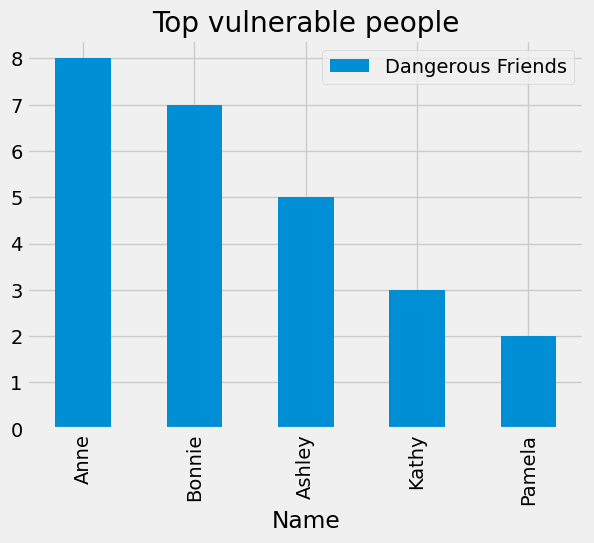

In [31]:
result.plot(x='Name', y='Dangerous Friends', kind='bar', title='Top vulnerable people')

Dangerous Family Friends

In [33]:
query = """MATCH (p:Person)-[:FAMILY_REL]-(relative)-[:KNOWS]-(famFriend)-[:PARTY_TO]->(:Crime)
WHERE NOT (p:Person)-[:PARTY_TO]->(:Crime) AND
 NOT (relative)-[:PARTY_TO]->(:Crime)
RETURN p.name AS Name, p.surname AS Surname, p.nhs_no AS id, count(DISTINCT famFriend) AS `Dangerous Family Friends`
ORDER BY `Dangerous Family Friends` DESC
LIMIT 5"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Surname,id,Dangerous Family Friends
0,Kimberly,Alexander,548-59-5017,7
1,Walter,Wheeler,263-14-7231,2
2,Kimberly,Wood,859-40-9947,2
3,Henry,Palmer,219-06-7487,2
4,Andrea,Moreno,240-77-5251,2


Visualization of dangerous Family Friends

<AxesSubplot: title={'center': 'Dangerous Family Friends'}, xlabel='Name'>

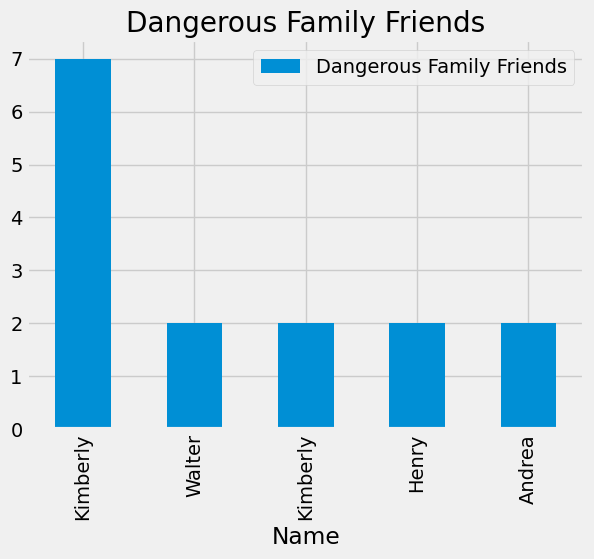

In [34]:
result.plot(x='Name', y='Dangerous Family Friends', kind='bar', title='Dangerous Family Friends')

# Section-3: Applying Graph Algorithm

Computing Betweenness Centrality Algorithm

In [35]:
graph.run("""
CALL gds.betweenness.write('myGraph', { writeProperty: 'betweenness' })
YIELD centralityDistribution, nodePropertiesWritten
RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, nodePropertiesWritten;
""").to_data_frame()

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.betweenness.write`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.

Computing Clossness

In [36]:
graph.run("""
CALL gds.alpha.closeness.write({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED',
  writeProperty: 'closeness'
}) YIELD nodes, writeProperty;
""").to_data_frame()

,nodes,writeProperty
0,997,closeness


In [37]:
graph.run("""
CALL gds.alpha.closeness.stream({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED',
  improved:true 
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).id AS user, centrality
ORDER BY centrality DESC;
""").to_data_frame()

,user,centrality
0,76024415,0.000
1,76017666,0.000
2,76014286,0.000
3,76013293,0.000
4,76012714,0.000
...,...,...
992,75143948,0.000
993,75132155,0.000
994,75127693,0.000
995,75122843,0.000


In [38]:
graph.run("""
CALL gds.alpha.closeness.harmonic.stream({
  nodeProjection: 'Question',
  relationshipProjection: 'TAGGED'
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).id AS user, centrality
ORDER BY centrality DESC
;
""").to_data_frame()

,user,centrality
0,76024415,0.000
1,76017666,0.000
2,76014286,0.000
3,76013293,0.000
4,76012714,0.000
...,...,...
992,75143948,0.000
993,75132155,0.000
994,75127693,0.000
995,75122843,0.000


In [ ]:
Computing PageRank

In [39]:
graph.run("""
CALL gds.pageRank.write('myGraph', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
})
YIELD nodePropertiesWritten, ranIterations;
""").to_data_frame()

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.pageRank.write`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.